In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import re
import matplotlib.pyplot as plt

In [13]:
def extract_torque(value):
    """Extract torque value from string"""
    try:
        match = re.search(r'(\d+\.?\d*)Nm', str(value))
        if match:
            return float(match.group(1))
    except:
        pass
    return np.nan

def extract_power(value):
    """Extract power value from string"""
    try:
        match = re.search(r'(\d+\.?\d*)bhp', str(value))
        if match:
            return float(match.group(1))
    except:
        pass
    return np.nan

def preprocess_data(train_path, test_path, validation_size=0.2, random_state=42):
    """Load and preprocess train and test data"""
    # Load data
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # Check if target column exists in test data
    has_test_target = 'is_claim' in test_data.columns
    
    # Extract numerical values from max_torque and max_power
    train_data['max_torque'] = train_data['max_torque'].apply(extract_torque)
    test_data['max_torque'] = test_data['max_torque'].apply(extract_torque)
    
    train_data['max_power'] = train_data['max_power'].apply(extract_power)
    test_data['max_power'] = test_data['max_power'].apply(extract_power)
    
    # Define binary columns (convert Yes/No to 1/0)
    binary_cols = [
        'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 
        'is_parking_camera', 'is_front_fog_lights', 'is_rear_window_wiper', 
        'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 
        'is_power_door_locks', 'is_central_locking', 'is_power_steering', 
        'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 
        'is_ecw', 'is_speed_alert'
    ]
    
    for col in binary_cols:
        train_data[col] = train_data[col].map({'Yes': 1, 'No': 0}).fillna(0)
        test_data[col] = test_data[col].map({'Yes': 1, 'No': 0}).fillna(0)
    
    # Define categorical columns for encoding
    categorical_cols = [
        'area_cluster', 'make', 'segment', 'model', 'fuel_type', 
        'engine_type', 'rear_brakes_type', 'transmission_type', 
        'gear_box', 'steering_type'
    ]
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        # Combine train and test for encoding to handle all categories
        combined = pd.concat([train_data[col], test_data[col]], axis=0)
        le.fit(combined.astype(str))
        train_data[col] = le.transform(train_data[col].astype(str))
        test_data[col] = le.transform(test_data[col].astype(str))
        label_encoders[col] = le
    
    # Define numerical columns (excluding ID and target)
    numerical_cols = [
        'policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density',
        'airbags', 'displacement', 'cylinder', 'turning_radius', 'length', 'width',
        'height', 'gross_weight', 'ncap_rating', 'max_torque', 'max_power'
    ] + binary_cols
    
    # All feature columns
    feature_cols = numerical_cols + categorical_cols
    
    # Prepare features and target for train
    X_train = train_data[feature_cols]
    y_train = train_data['is_claim']
    
    # Prepare test features
    X_test = test_data[feature_cols]
    
    # If test has target, use it for evaluation
    if has_test_target:
        y_test = test_data['is_claim']
        X_train_final = X_train
        y_train_final = y_train
        X_test_final = X_test
        y_test_final = y_test
    else:
        # If test doesn't have target, split train data for validation
        print("Test data doesn't contain target variable. Using train/validation split.")
        X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
            X_train, y_train, test_size=validation_size, random_state=random_state
        )
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train_final)
    X_test_imputed = imputer.transform(X_test_final)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_final.values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_final.values, dtype=torch.float32).view(-1, 1)
    
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, feature_cols, has_test_target


In [23]:
# Define neural network
class InsuranceNet(nn.Module):
    def __init__(self, input_size):
        super(InsuranceNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 84)
        self.layer2 = nn.Linear(84, 72)
        self.layer3 = nn.Linear(72, 64)
        self.layer4 = nn.Linear(64, 48)
        self.layer5 = nn.Linear(48, 36)
        self.layer6 = nn.Linear(36, 24)
        self.layer7 = nn.Linear(24, 16)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.relu(self.layer6(x))
        x = self.relu(self.layer7(x))
        x = self.sigmoid(self.output(x))
        return x



In [24]:
def train_model(model, X_train, y_train, epochs=350):
    """Train the neural network model"""
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    losses = []
    epochs_plt = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            losses.append(loss.item())
            epochs_plt.append(epoch+1)
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    return losses, epochs_plt

def evaluate_model(model, X_train, y_train, X_test, y_test, has_test_target):
    """Evaluate model performance"""
    model.eval()
    with torch.no_grad():
        # Test predictions
        y_pred_proba = model(X_test).numpy()
        y_pred_binary = (y_pred_proba > 0.5).astype(int)
        
        # Train predictions
        train_proba = model(X_train).numpy().flatten()
    
    # Test metrics
    test_roc_auc = roc_auc_score(y_test.numpy(), y_pred_proba)
    test_mae = mean_absolute_error(y_test.numpy(), y_pred_proba)
    
    # Train metrics
    train_roc_auc = roc_auc_score(y_train.numpy(), train_proba)
    
    # Print appropriate messages based on data source
    if has_test_target:
        print(f'Test ROC-AUC: {test_roc_auc:.4f}')
        print(f'Test MAE: {test_mae:.4f}')
    else:
        print(f'Validation ROC-AUC: {test_roc_auc:.4f}')
        print(f'Validation MAE: {test_mae:.4f}')
    
    print(f'Train ROC-AUC: {train_roc_auc:.4f}')
    print(f'Difference: {train_roc_auc - test_roc_auc:.4f}')
    
    return test_roc_auc, test_mae, train_roc_auc


Loading and preprocessing data...
Test data doesn't contain target variable. Using train/validation split.
Number of features: 42
Train shape: torch.Size([46873, 42])
Test shape: torch.Size([11719, 42])
Using validation split from train data for evaluation.
Model initialized with input size: 42

Training model...
Epoch [10/350], Loss: 0.6539
Epoch [20/350], Loss: 0.6226
Epoch [30/350], Loss: 0.4852
Epoch [40/350], Loss: 0.2578
Epoch [50/350], Loss: 0.2523
Epoch [60/350], Loss: 0.2462
Epoch [70/350], Loss: 0.2373
Epoch [80/350], Loss: 0.2349
Epoch [90/350], Loss: 0.2344
Epoch [100/350], Loss: 0.2339
Epoch [110/350], Loss: 0.2336
Epoch [120/350], Loss: 0.2333
Epoch [130/350], Loss: 0.2331
Epoch [140/350], Loss: 0.2329
Epoch [150/350], Loss: 0.2327
Epoch [160/350], Loss: 0.2326
Epoch [170/350], Loss: 0.2325
Epoch [180/350], Loss: 0.2324
Epoch [190/350], Loss: 0.2322
Epoch [200/350], Loss: 0.2322
Epoch [210/350], Loss: 0.2321
Epoch [220/350], Loss: 0.2320
Epoch [230/350], Loss: 0.2319
Epoc

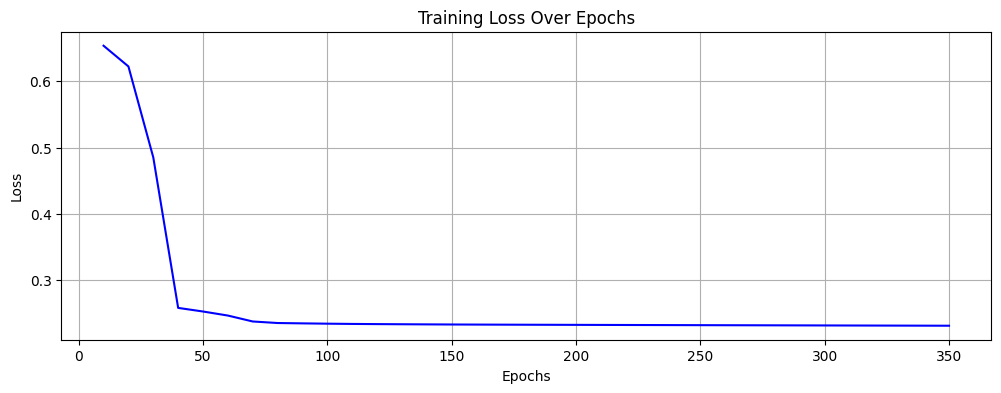

In [25]:

train_path = 'D:/my_ML/diploma_polytech/data/raw/train_new_ds.csv'
test_path = 'D:/my_ML/diploma_polytech/data/raw/test_new_ds.csv'
    
    # Preprocess data
print("Loading and preprocessing data...")
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, feature_cols, has_test_target = preprocess_data(train_path, test_path)
    
print(f"Number of features: {len(feature_cols)}")
print(f"Train shape: {X_train_tensor.shape}")
print(f"Test shape: {X_test_tensor.shape}")
    
if has_test_target:
    print("Using original test set for evaluation.")
else:
     print("Using validation split from train data for evaluation.")
    
    # Initialize model
input_size = X_train_tensor.shape[1]
model = InsuranceNet(input_size)
print(f"Model initialized with input size: {input_size}")
    
    # Train model
print("\nTraining model...")
losses, epochs_plt = train_model(model, X_train_tensor, y_train_tensor)
    
    # Evaluate model
print("\nEvaluating model...")
test_roc_auc, test_mae, train_roc_auc = evaluate_model(
        model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, has_test_target
)
    
    # Plot training loss
plt.figure(figsize=(12, 4))
plt.plot(epochs_plt, losses, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()
